# Prueba de streamlines

Cambio al directorio de abajo.

No correr más de una vez porque se pierde la referencia

In [1]:
import os

notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')

os.chdir(base_dir)

# print(os.getcwd())

Importo módulos necesarios

In [2]:
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

### Carga de datos de OpenFOAM en la isosuperficie

In [3]:
from load_txt_datos import cargar_datos

file = 'U_superficie_gondolas_337.raw'
path = os.path.join(base_dir, 'data', file)

x, y, z, u, v, w = cargar_datos('isosuperficie', path)

minx, maxx = x.min(), x.max()
miny, maxy = y.min(), y.max()

# print(minx, maxx)
# print(miny, maxy)

### Interpolación de los datos en una grilla regular con densidad definida y (posiblemente) dimensión menor a la isosuperficie de OF

In [4]:
from scipy.interpolate import griddata

npois = 100
npoiX, npoiY = npois, npois

meshXmin, meshXmax = 1000, 5000
meshYmin, meshYmax = 1000, 5000

xg = np.linspace(meshXmin, meshXmax, npoiX)
yg = np.linspace(meshYmin, meshYmax, npoiY)

XG, YG = np.meshgrid(xg, yg)

# Vertical displacement of mesh nodes
ZG = griddata((x, y), z, (XG, YG), method='linear')
UG = griddata((x, y), u, (XG, YG), method='linear')
VG = griddata((x, y), v, (XG, YG), method='linear')
WG = griddata((x, y), w, (XG, YG), method='linear')

# %timeit WG = griddata((x, y), w, (XG, YG), method='linear')
# %timeit WG = griddata((x, y), w, (XG, YG), method='cubic')

### Evaluación de diferentes interpoladores sobre la grilla regular

In [5]:
from scipy.interpolate import interp2d

# %timeit interp_u = interp2d(XG, YG, UG)
# interp_u = interp2d(XG, YG, UG)
# %timeit interp_u(2000, 2000)

# La forma siguiente tarda 4 órdenes de magnitud menos con 100*100 puntos
# y 5 órdenes para 200 puntos
%timeit interp_u2 = interp2d(xg, yg, UG, kind='linear')
interp_u2 = interp2d(xg, yg, UG)
%timeit interp_u2(2000, 2000)

324 µs ± 21.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
12.7 µs ± 274 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [6]:
from scipy.interpolate import RectBivariateSpline

# Esta forma tarda unas 6 veces menos en las evaluaciones, la definición tarda igual
%timeit interp_u2 = RectBivariateSpline(xg, yg, UG, kx=1, ky=1)
interp_u2 = RectBivariateSpline(xg, yg, UG)
%timeit interp_u2(2000, 2000)

325 µs ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.57 µs ± 272 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
_interp_u = RectBivariateSpline(xg, yg, UG)
_interp_v = RectBivariateSpline(xg, yg, VG)
_interp_w = RectBivariateSpline(xg, yg, WG)
_interp_z = RectBivariateSpline(xg, yg, ZG)

### Función de cálculo de las streamlines 
(cuidado que no pertenece a una clase y entonces el primer parámetro no es self)

In [8]:
def _makeHalfStreamline(x0, y0, xmin, xmax, ymin, ymax, dr, sign):
    """
    Compute a streamline extending in one direction from the given point.
    """
    # TODO: can we vectorize this?
    
    sx = []
    sy = []

    x = x0
    y = y0

    while xmin < x < xmax and ymin < y < ymax:
        sx.append(x)
        sy.append(y)
        
#         print(x, y)

        u = _interp_u(x, y).item()
        v = _interp_v(x, y).item()
        
#         print(u, v)
        scale = sign * (dr / np.sqrt(u**2 + v**2))

        x += scale * u
        y += scale * v


    return sx, sy


### Cómputo de varias streamlines

In [9]:
# %%timeit
x0 = list(range(1100, 5000, 500)) 
y0 = [4900] * len(x0)

# print(_interp_u([meshXmin] , [meshYmin]).item())

dr = 200
sign = 1

streamlines = [_makeHalfStreamline(*xy, meshXmin, meshXmax, meshYmin, meshYmax, dr, sign) for xy in zip(x0, y0)]

# streamline = _makeHalfStreamline(x0, y0, meshXmin, meshXmax, meshYmin, meshYmax, dr, sign)

# print(len(streamline[0]))

### Ploteo de las streamlines
Los puntos rojos pertenecen a las streamlines calculadas, líneas negras son las streamlines calculadas por matplotlib y el color del fondo es la altura del terreno.

<IPython.core.display.Javascript object>


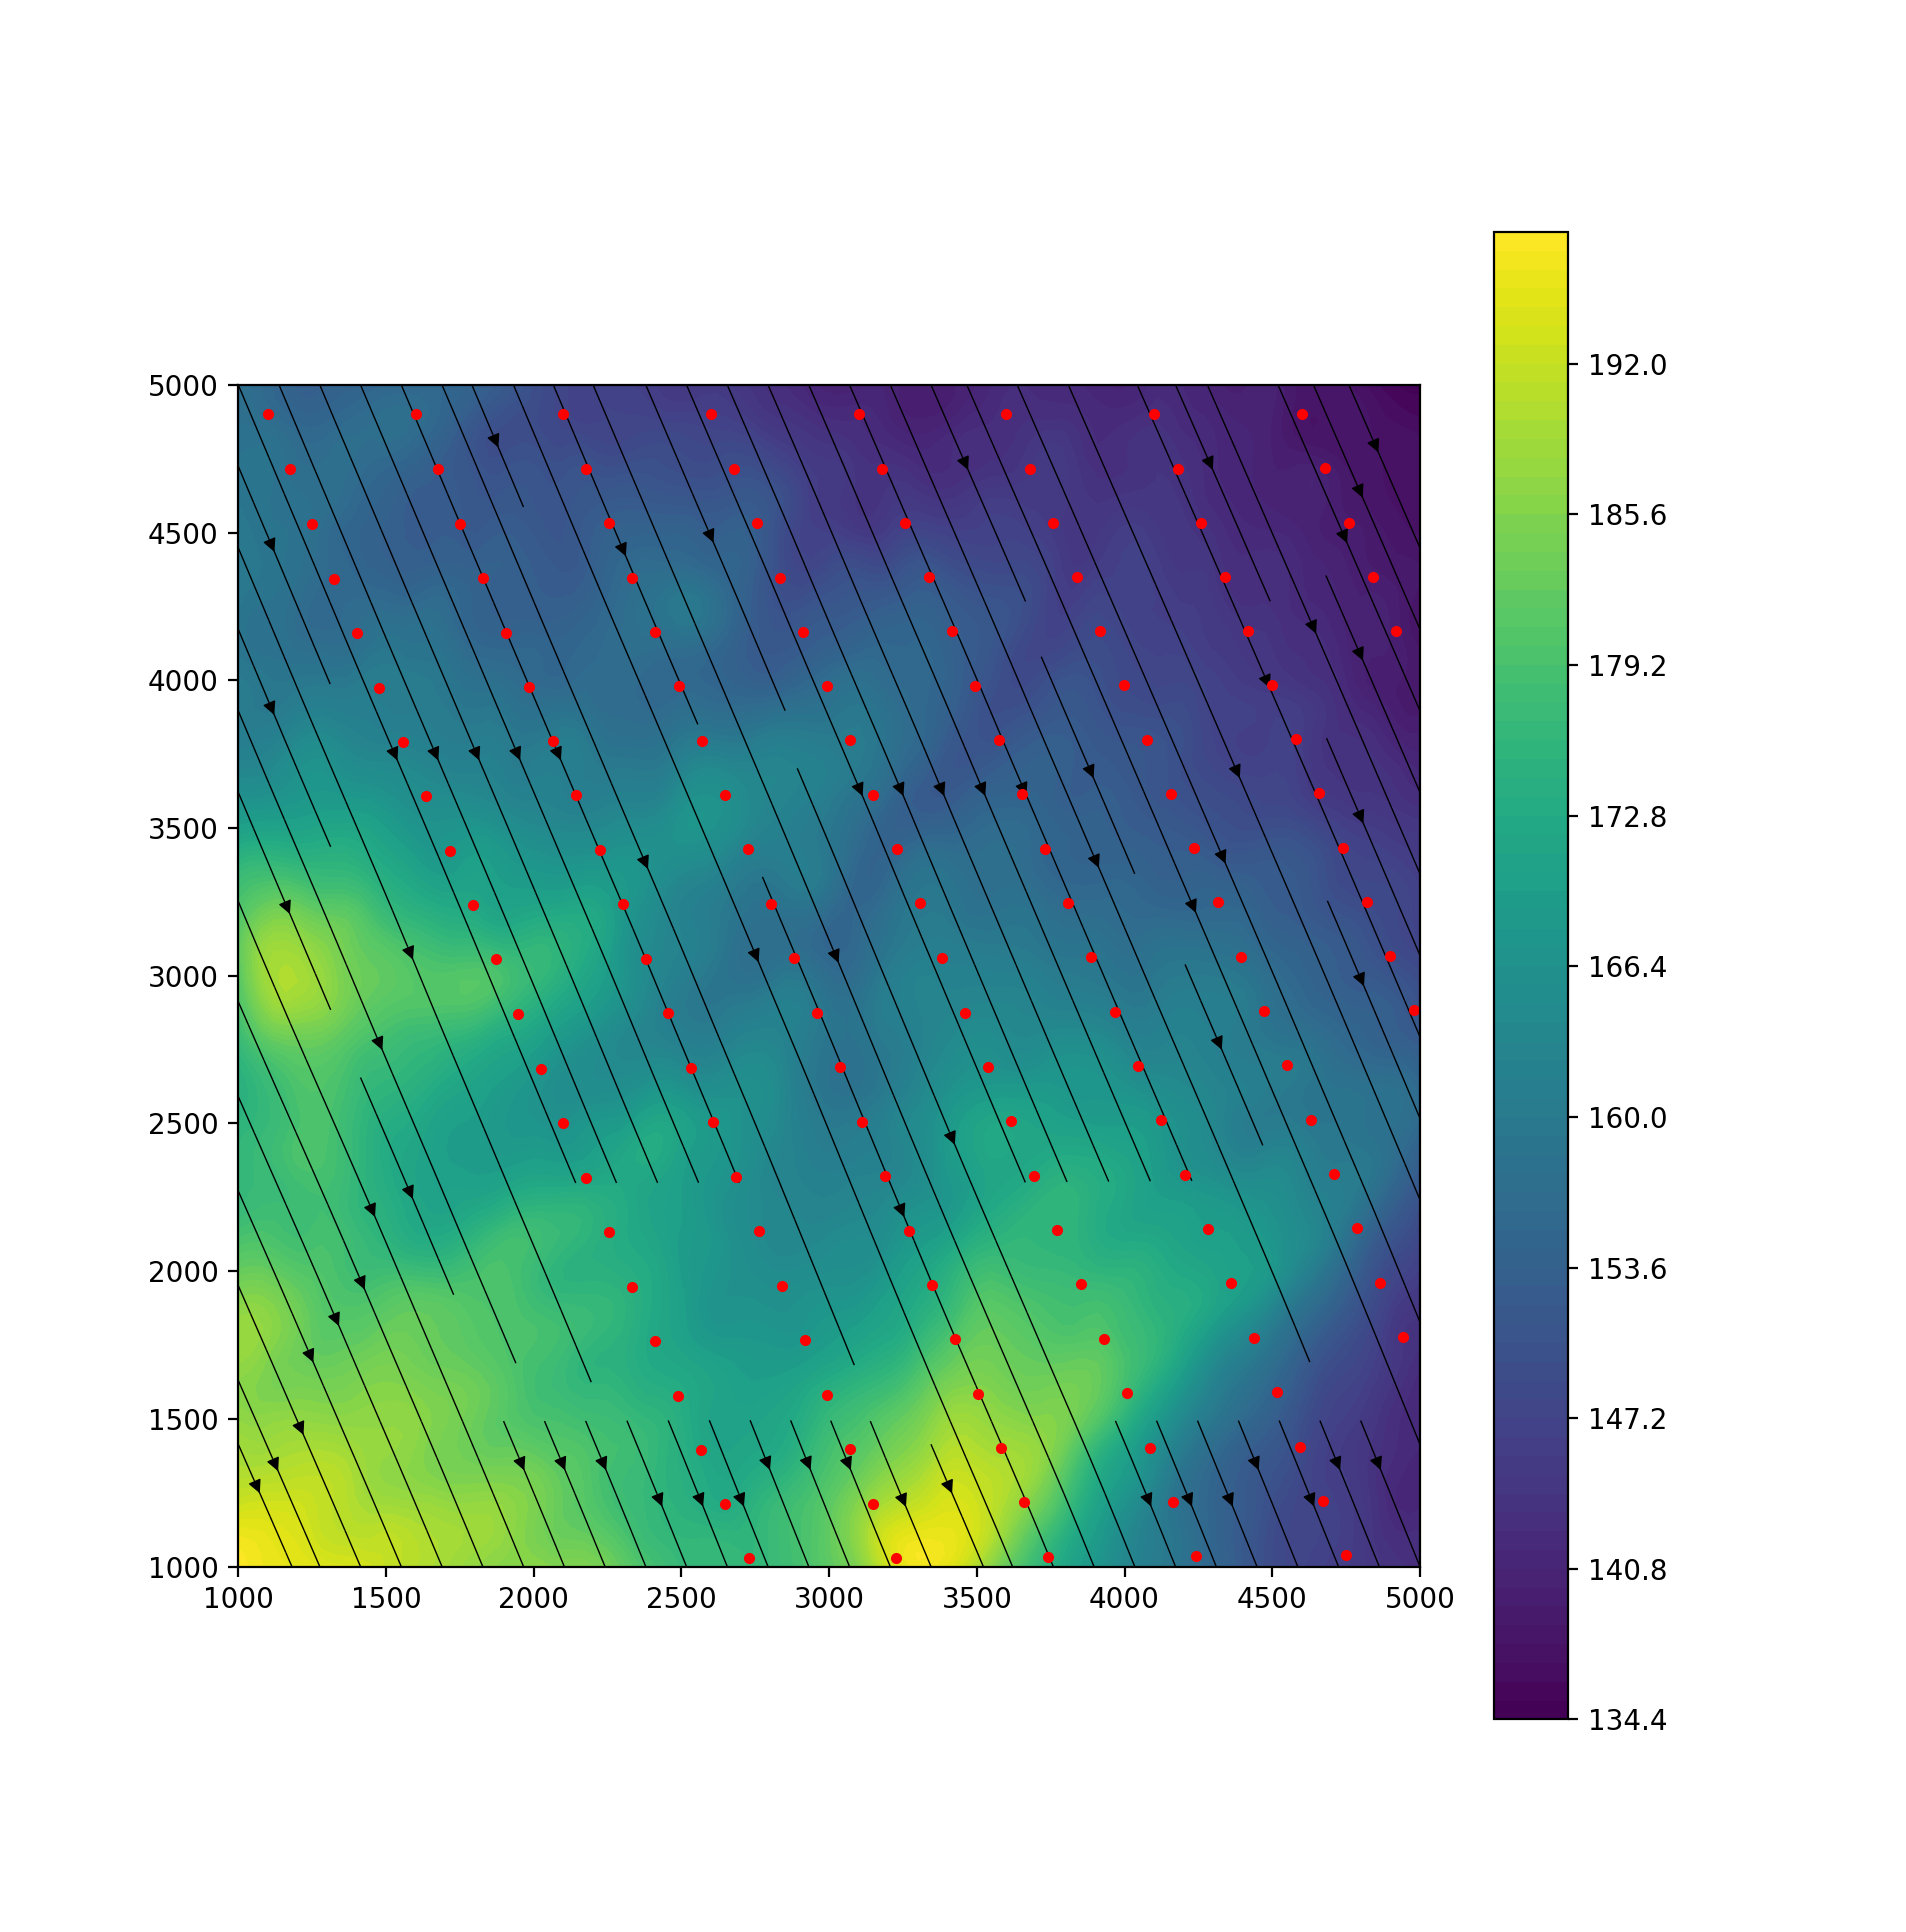

In [10]:
fig1 = plt.figure()
ax = fig1.add_subplot(1, 1, 1)

count = ax.contourf(XG, YG, ZG, 100)
# ax.plot(*streamline, '.')

for line in streamlines:
    ax.plot(*line, '.r')

    
ax.streamplot(XG, YG, UG, VG, color='k', linewidth=.5)
fig1.colorbar(count)
ax.set_aspect('equal', 'box')
